# Код

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
from collections import Counter
from itertools import zip_longest

In [2]:
def gen_fastq(filename, quality_offset=33):
    # Генератор из FASTQ (чтобы не читать целиком)
    gzipped = filename.endswith('.gz')
    with (gzip.open(filename, 'rb') if gzipped else open(filename, 'r')) as fi:
        for lines in zip_longest(*[fi] * 4):
            if gzipped:
                lines = [line.decode() for line in lines]
            lines = [line.strip() for line in lines]
            
            assert lines[0][0] == '@', 'Неправильная строка с идентификатором'
            assert len(lines[1]) == len(lines[3]), 'Не совпадают длины строк последовательности и качества'
            
            yield {'identifier': lines[0][1:],
                   'sequence': lines[1], 
                   'quality': np.array([ord(x) - quality_offset for x in lines[3]]),
                   'length': len(lines[1])}

In [3]:
def GC_content(read, quality_cutoff=0, length_cutoff=0):
    # Считает GC содержание 
    # quality_cutoff - минимальное качество нуклеотида, которое будет учитываться
    # length_cutoff - минимальная длина ридов (после фильтрации по качеству), которые будут учитываться
    
    filtered_seq = [n for n, q in zip(read['sequence'], read['quality']) if q >= quality_cutoff]
    if len(filtered_seq) < length_cutoff:
        return np.nan
    gc = sum(n == 'G' or n == 'C' for n in filtered_seq)
    return gc / read['length']

In [4]:
def qual2prob(quality):
    return 10 ** (-quality / 10)

In [6]:
def add(X, Y):
    # Складывает два numpy массива, дополняет нулями справа, если длины не равны
    n = len(X)
    m = len(Y)
    return (np.append(X, np.zeros(m - n)) if m > n else X) + (np.append(Y, np.zeros(n - m)) if n > m else Y)

In [7]:
def k_mers(sequence, k=4):
    # Генератор для к-меров
    for index in range(len(sequence) - k + 1):
        yield sequence[index : index + k]

# Расчёты

In [8]:
filename = 'frag.R1.fastq.gz'

In [39]:
GC = []
prob_sum = np.array([])
nums = np.array([])
k_mers_counter = Counter()

for read in gen_fastq(filename, quality_offset=64):
    GC.append(GC_content(read))
    
    prob_sum = add(prob_sum, qual2prob(read['quality']))
    nums = add(nums, np.ones(read['length']))
    
    k_mers_counter += Counter(k_mers(read['sequence']))

GC = np.array(GC)
GC = GC[~np.isnan(GC)]

prob_mean = prob_sum / nums

k_mers_dist = sorted(k_mers_counter.values(), reverse=True)

# Графики

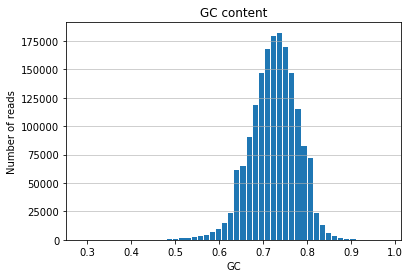

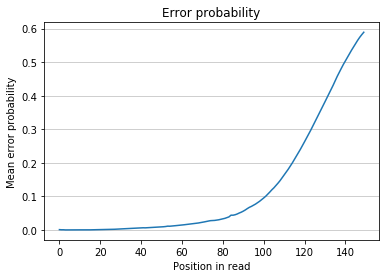

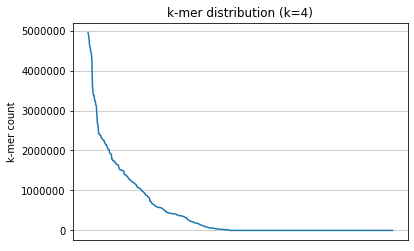

In [40]:
n, bins, patches = plt.hist(x=GC, bins=50,rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('GC')
plt.ylabel('Number of reads')
plt.title('GC content')
plt.show()

plt.plot(prob_mean)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Position in read')
plt.ylabel('Mean error probability')
plt.title('Error probability')
plt.show()

plt.plot(k_mers_dist)
plt.grid(axis='y', alpha=0.75)
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel('k-mers')
plt.ylabel('k-mer count')
plt.title('k-mer distribution (k=4)')
plt.show()

# Графики FastQC

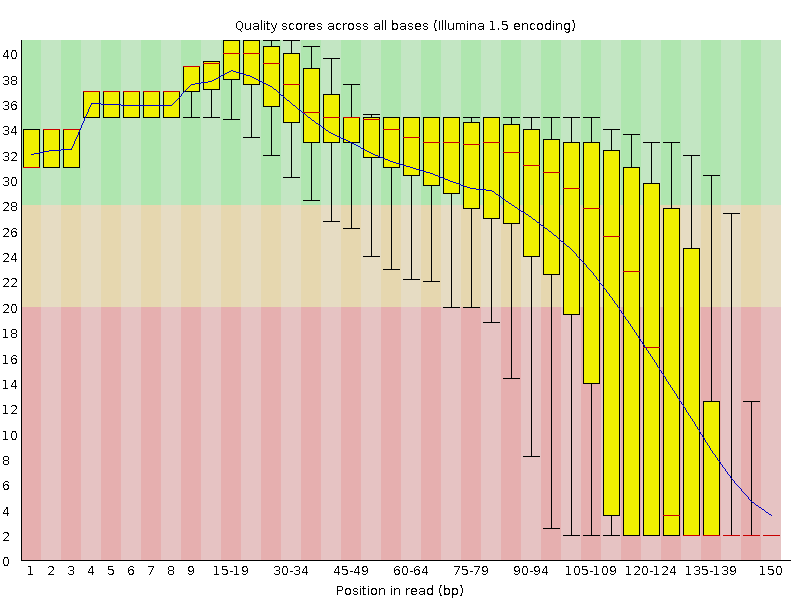

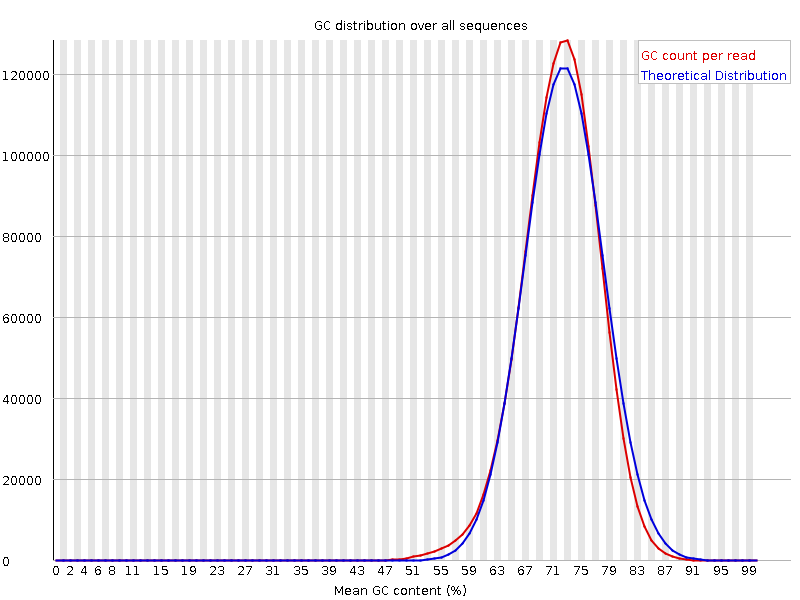

Графики визуально похожи, с учётом того, что в задании нарисована вероятность ошибки, а не качество, как в FastQC, которая тоже увеличивается на концах ридов соотв. снижению качества.

# Второй файл

# Расчёты

In [60]:
filename = 'frag.R2.fastq.gz'

In [61]:
GC = []
prob_sum = np.array([])
nums = np.array([])
k_mers_counter = Counter()

for read in gen_fastq(filename, quality_offset=64):
    GC.append(GC_content(read))
    
    prob_sum = add(prob_sum, qual2prob(read['quality']))
    nums = add(nums, np.ones(read['length']))
    
    k_mers_counter += Counter(k_mers(read['sequence']))

GC = np.array(GC)
GC = GC[~np.isnan(GC)]

prob_mean = prob_sum / nums

k_mers_dist = sorted(k_mers_counter.values(), reverse=True)

# Графики

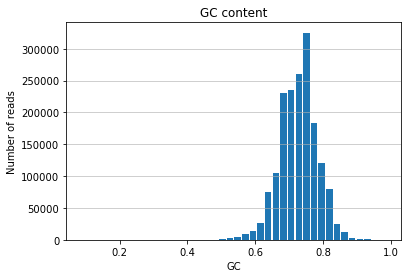

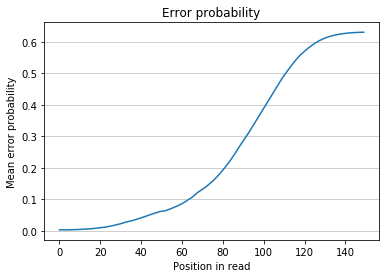

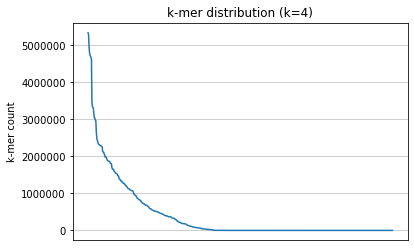

In [62]:
n, bins, patches = plt.hist(x=GC, bins=40,rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('GC')
plt.ylabel('Number of reads')
plt.title('GC content')
plt.show()

plt.plot(prob_mean)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Position in read')
plt.ylabel('Mean error probability')
plt.title('Error probability')
plt.show()

plt.plot(k_mers_dist)
plt.grid(axis='y', alpha=0.75)
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel('k-mers')
plt.ylabel('k-mer count')
plt.title('k-mer distribution (k=4)')
plt.show()

# FastQC

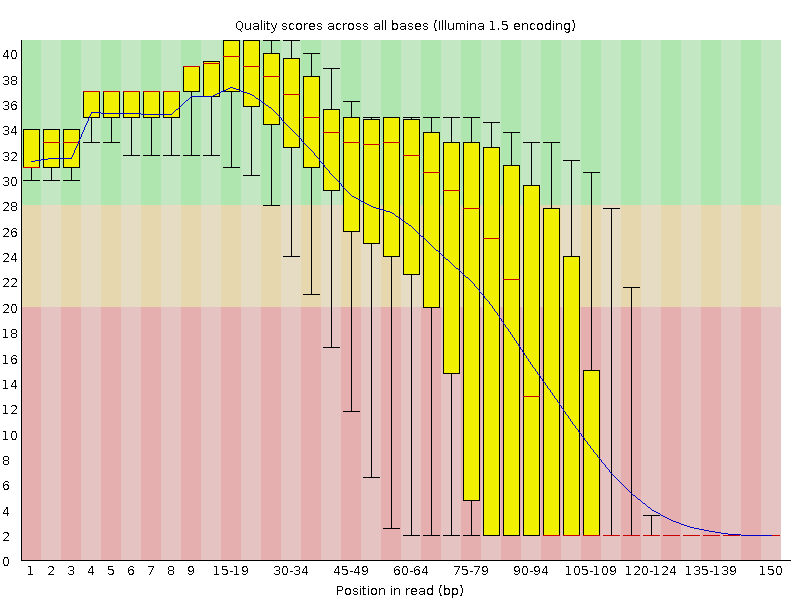

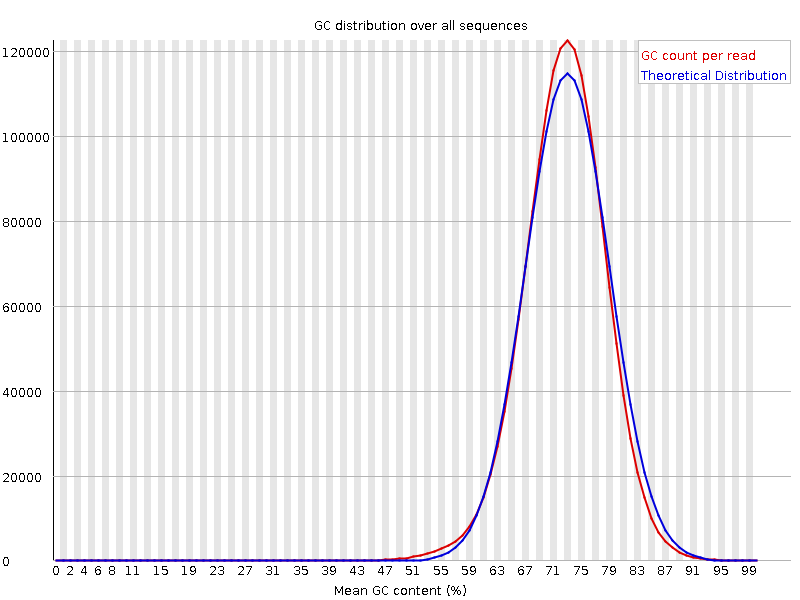

Графики показывают хуже качество на концах ридов и выше вероятность ошибки, чем в R1